In [106]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
import scipy
from scipy.special import logsumexp
from sklearn.utils import resample
import pandas as pd
from sklearn.cluster import KMeans
import re
import sys
from sklearn.manifold import TSNE


In [107]:
# Finding soft min
def find_soft_min(N, gamma, distance_matrix):
    distance_matrix = np.exp(- gamma * distance_matrix)
    softmins_values=[]
    for i in range(N):
        sum = np.sum(distance_matrix[i]) - 1 
        result = - np.log(sum / (N - 1)) / gamma
        softmins_values.append(result)
    return softmins_values

In [108]:
# Plotting Histograms
def plot_histograms(uci_data, categories, x_label):
    N, d = uci_data.shape
    plt.figure(figsize=(12, 6))
    for i in range(0,d):
        plt.hist(uci_data[..., i], bins=20, alpha=0.5, label=categories[i])
        plt.xlabel(x_label)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {categories[i]} Spending')
        plt.legend()
        plt.show()

In [109]:
# Plotting Scatter Plots
def generate_scatter_plots(uci_data, categories, title_text):
    N, d = uci_data.shape
    plt.figure(figsize=(12, 6))
    for i in range(0,d):
        for j in range(i+1, d):
            plt.scatter(uci_data[...,i], uci_data[...,j], alpha=0.5)
            plt.xlabel(categories[i])
            plt.ylabel(categories[j])
            plt.title(f'Distribution of {categories[i]} and {categories[j]}  {title_text}')
            plt.show()

In [110]:
# Calculate Anomaly Scores for each instance
def calculate_anomaly_scores(row_count, data, gamma):
    distances = cdist(data, data)  # Calculate pairwise distances between data points
    anomaly_scores = find_soft_min(row_count, gamma, distances)
    return anomaly_scores

In [111]:
# Rank Instances and Extract Top K Anomalies
def extract_top_anomalies(N, anomaly_scores, top_k):
    anomalies_df = pd.DataFrame({'AnomalyScore': anomaly_scores})
    index = pd.RangeIndex.from_range(range(0, N))
    anomalies_df['Instance'] = index
    top_anomalies = anomalies_df.nlargest(top_k, 'AnomalyScore')
    return top_anomalies

## Part 1 - Loading the Data, Preprocessing and Initial Data Analysis

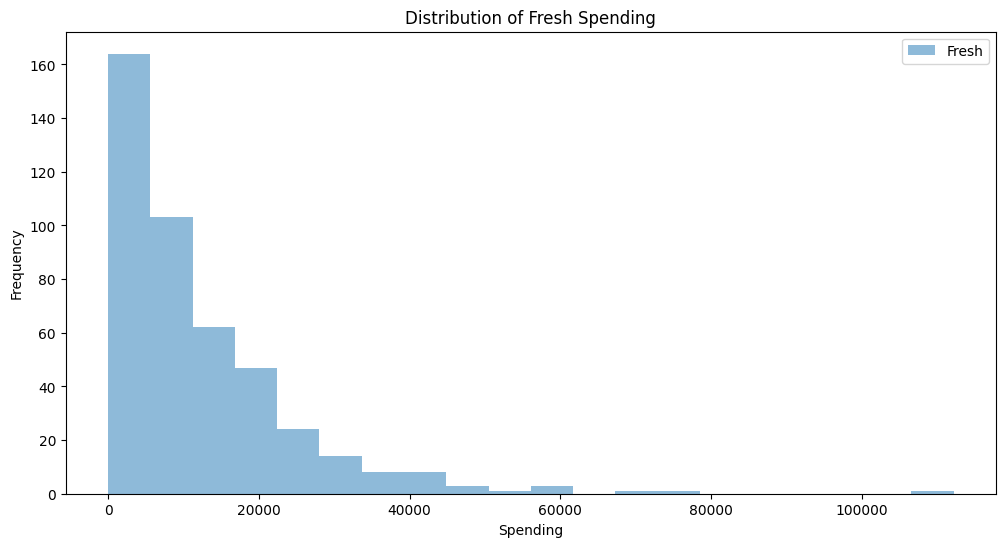

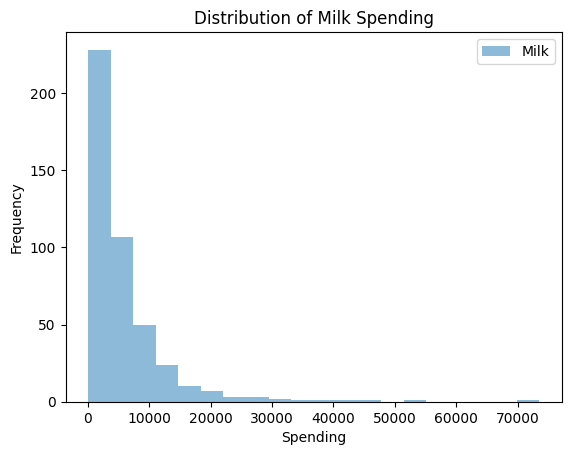

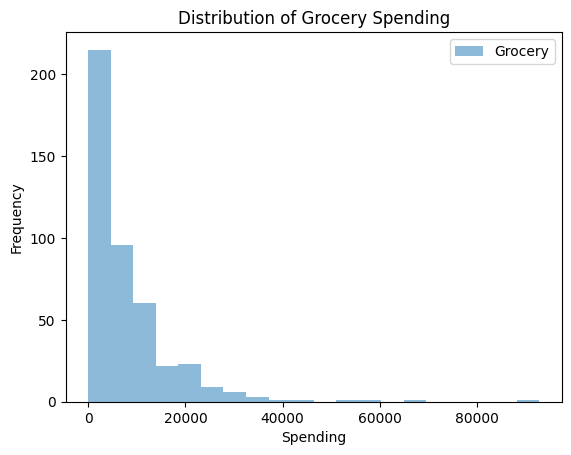

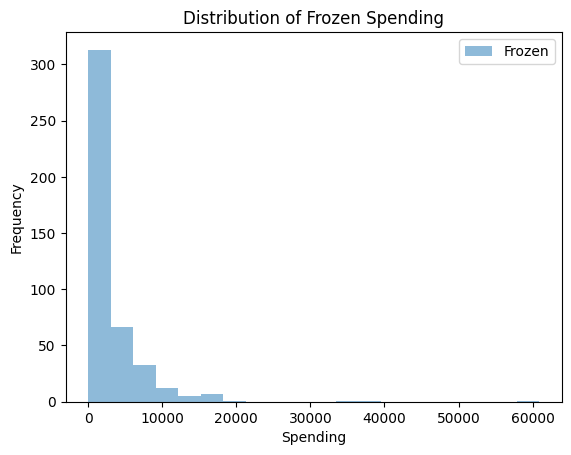

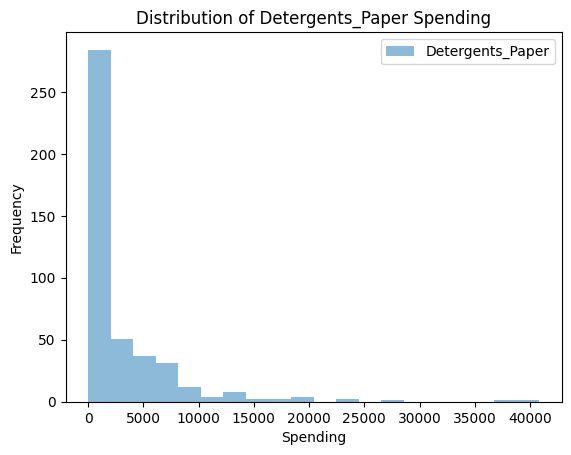

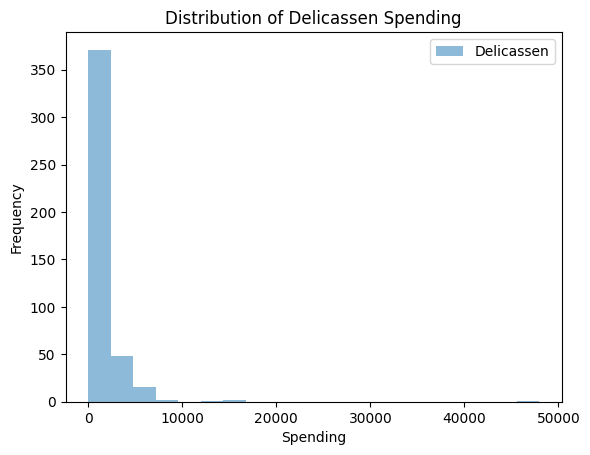

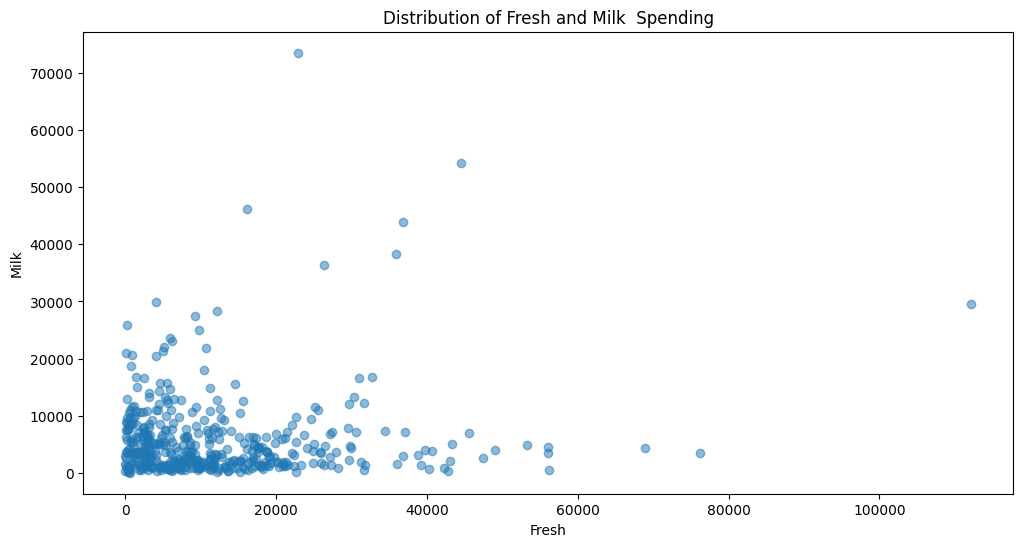

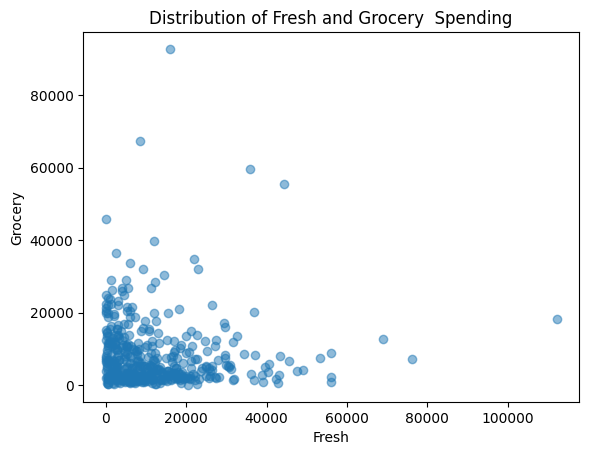

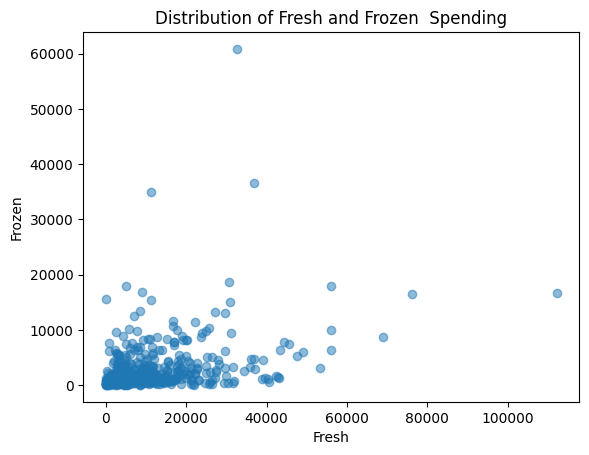

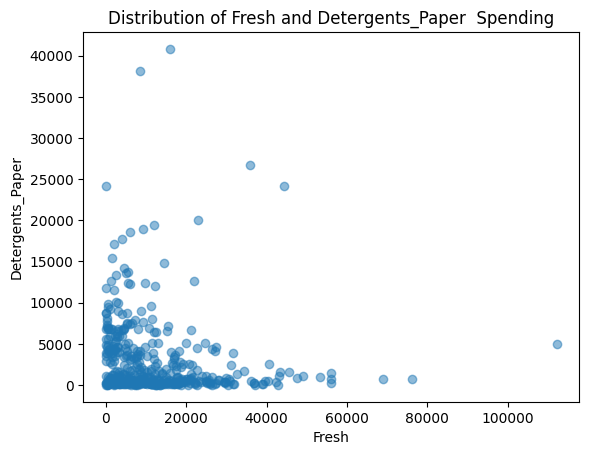

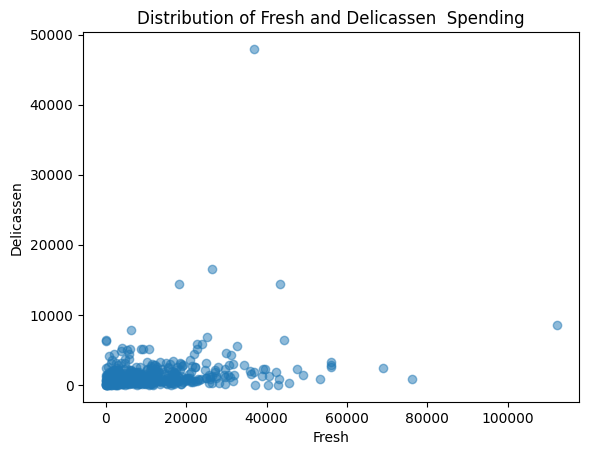

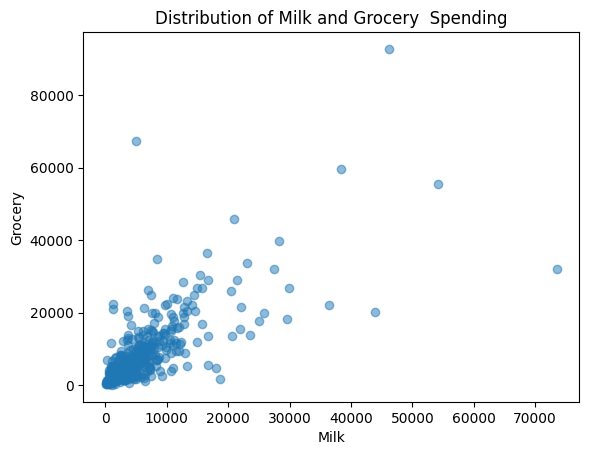

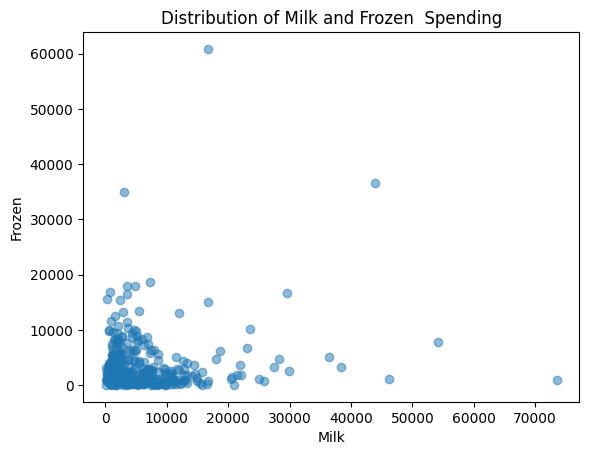

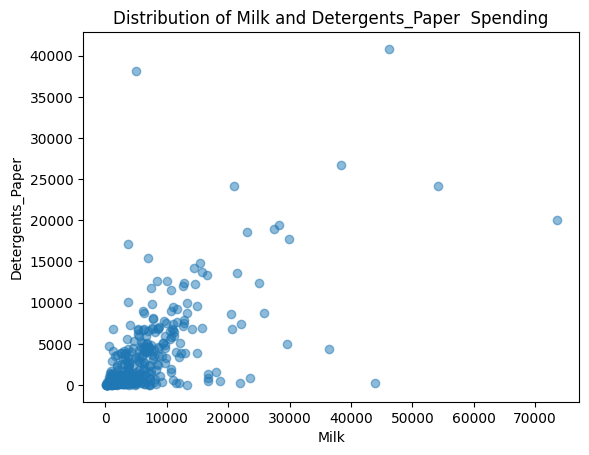

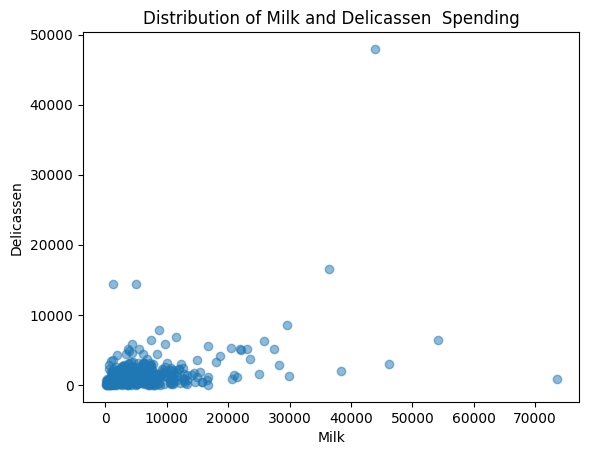

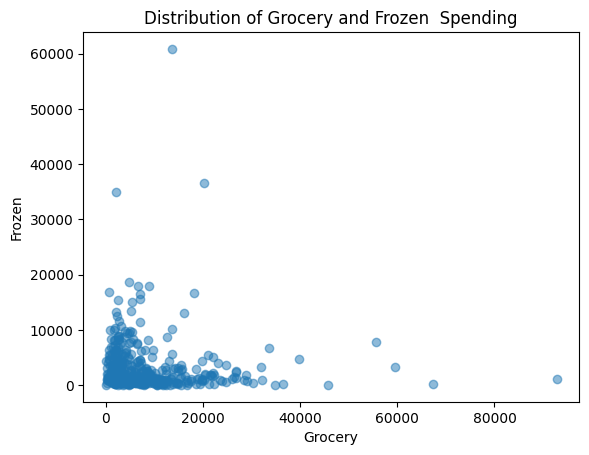

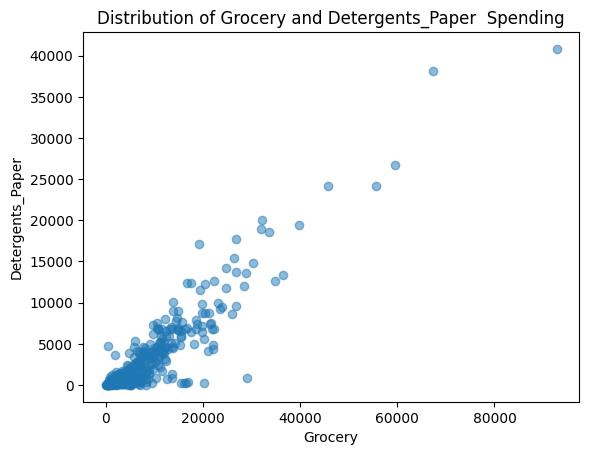

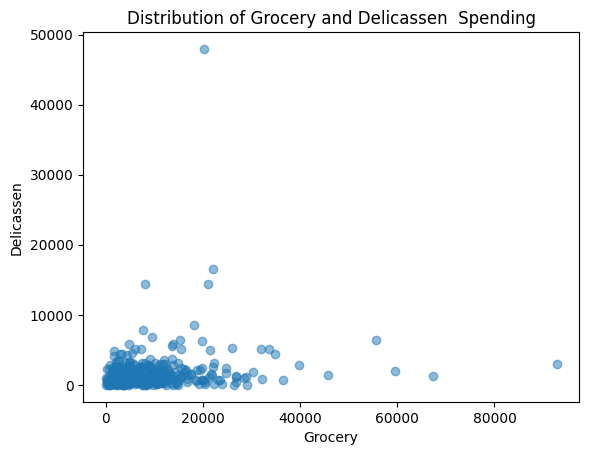

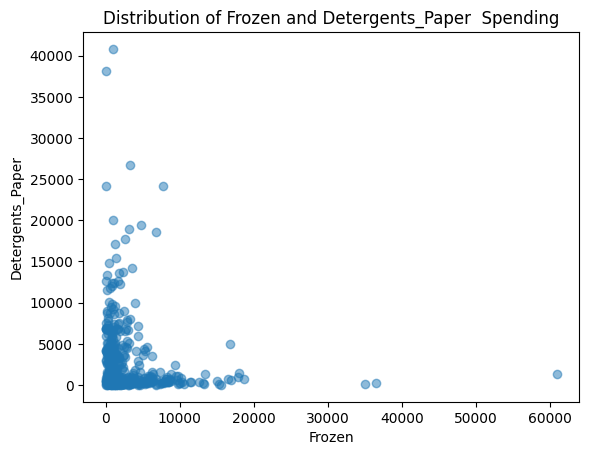

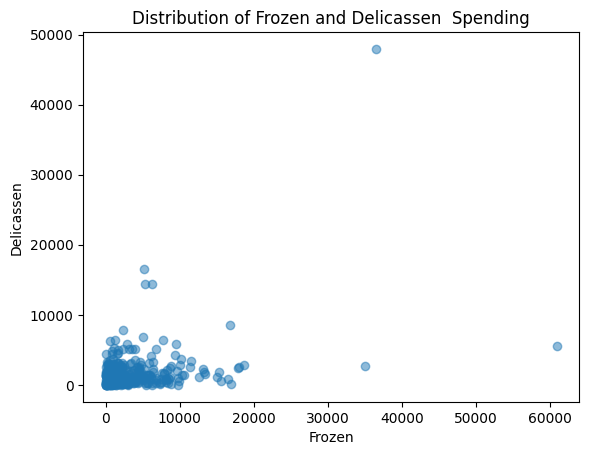

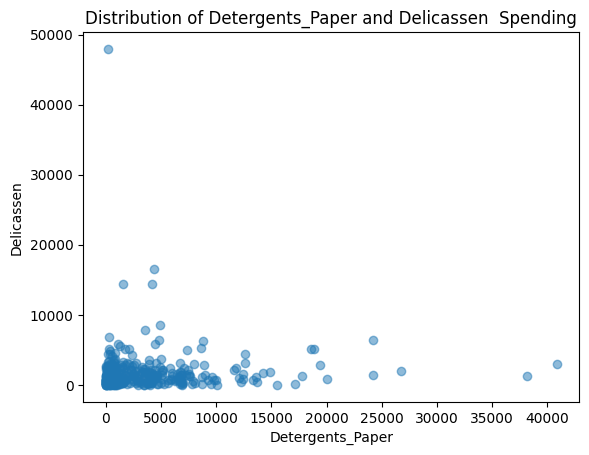

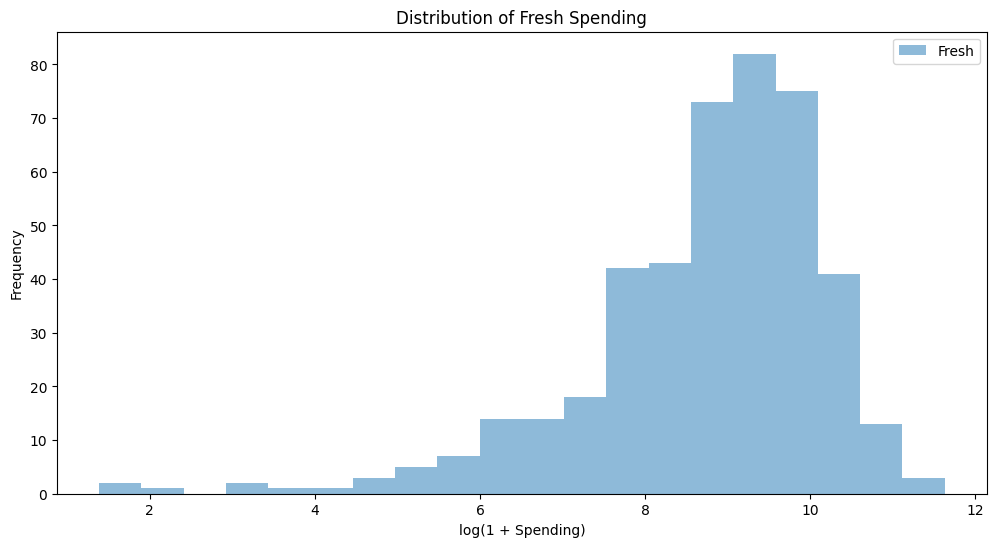

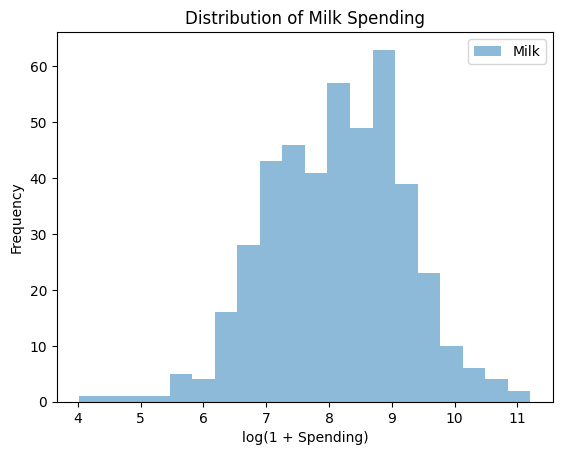

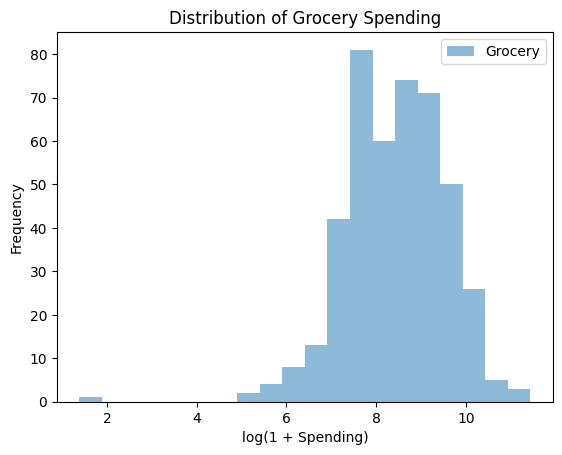

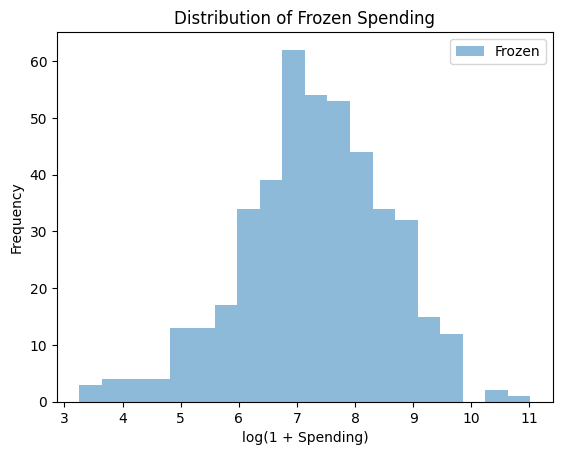

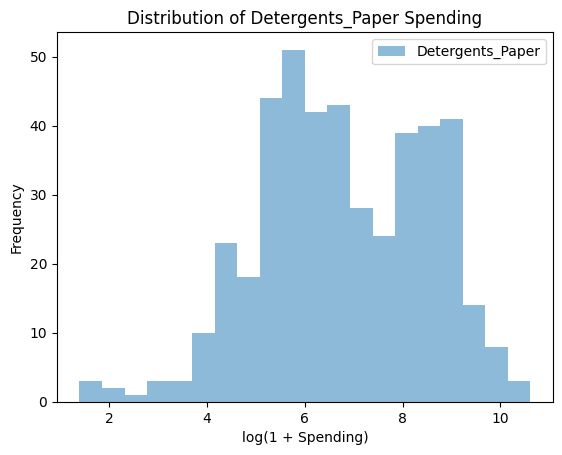

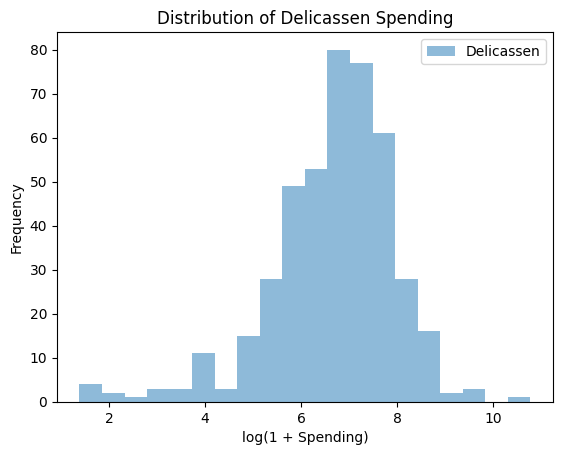

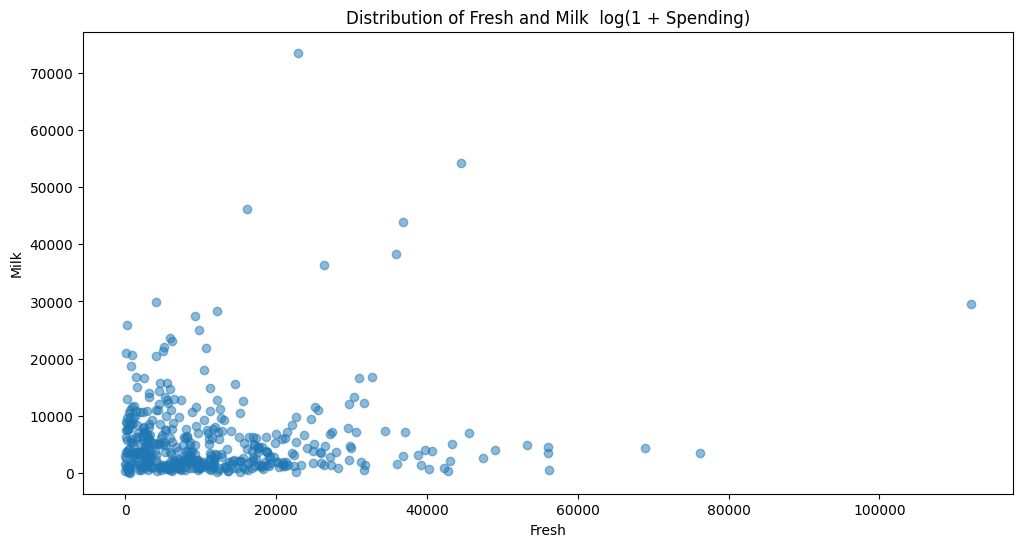

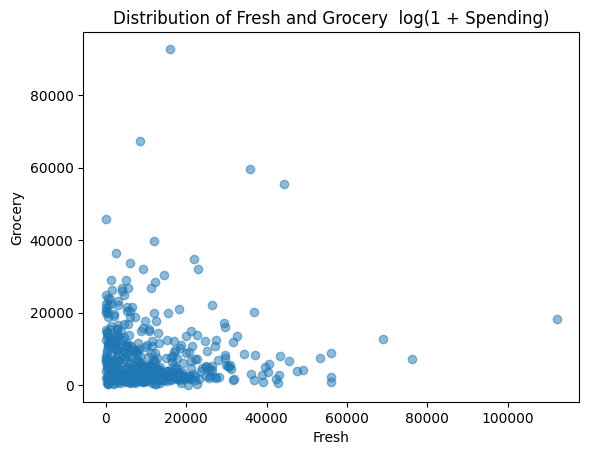

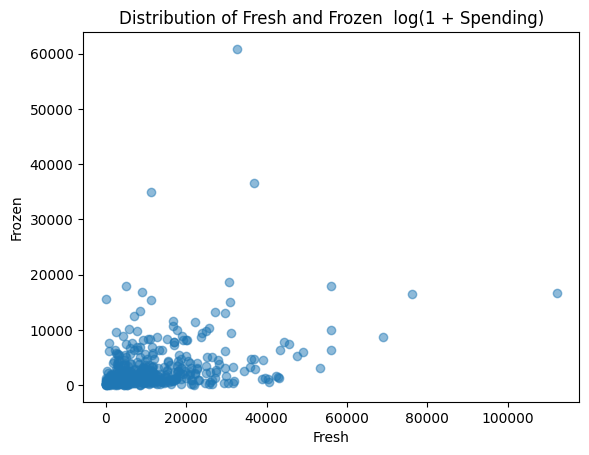

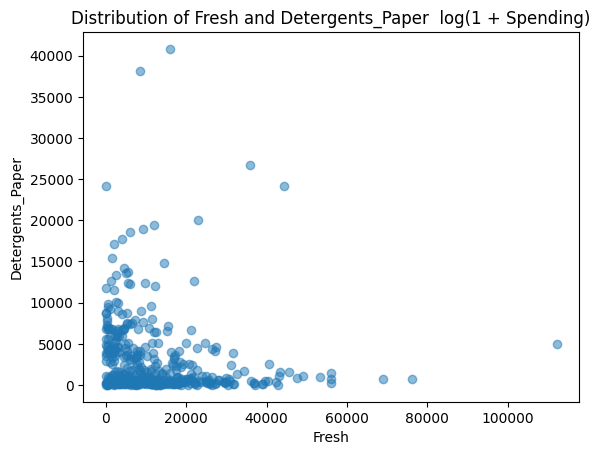

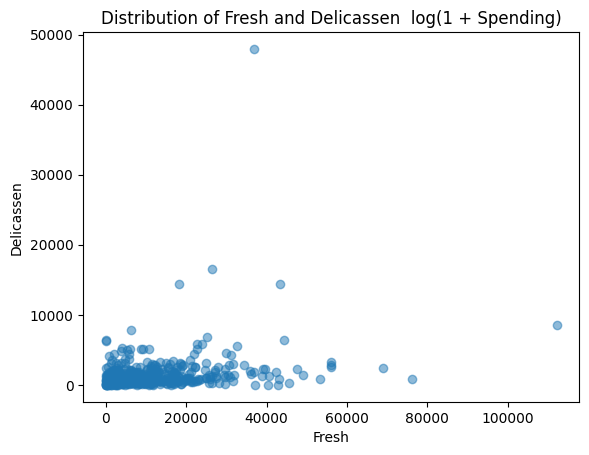

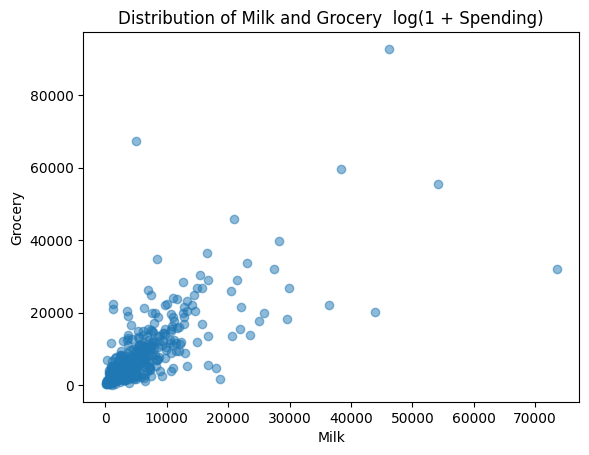

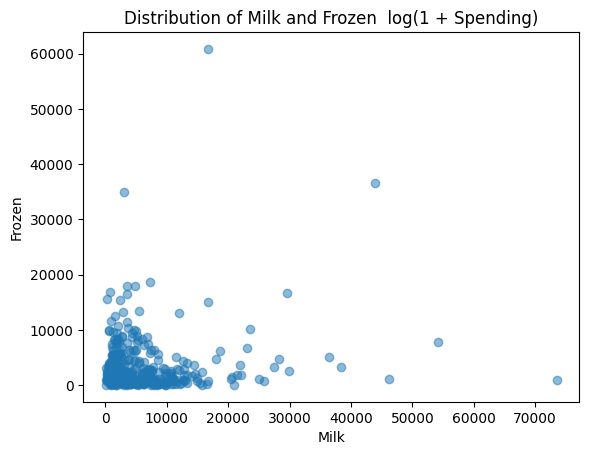

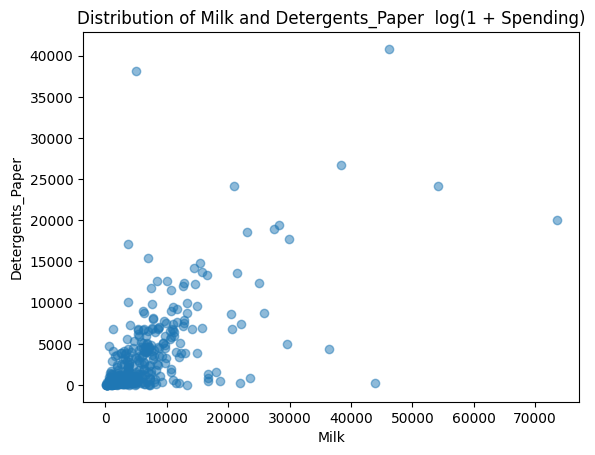

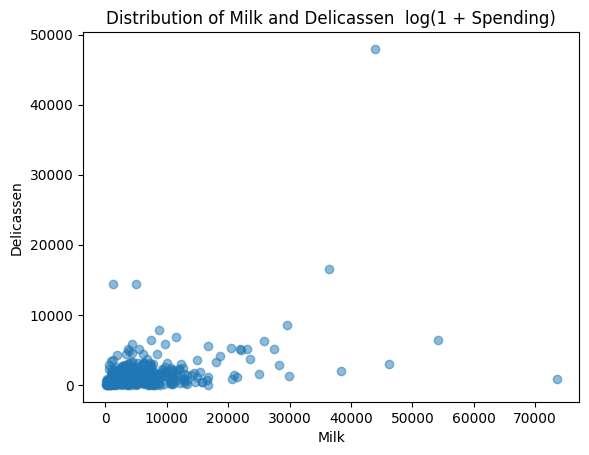

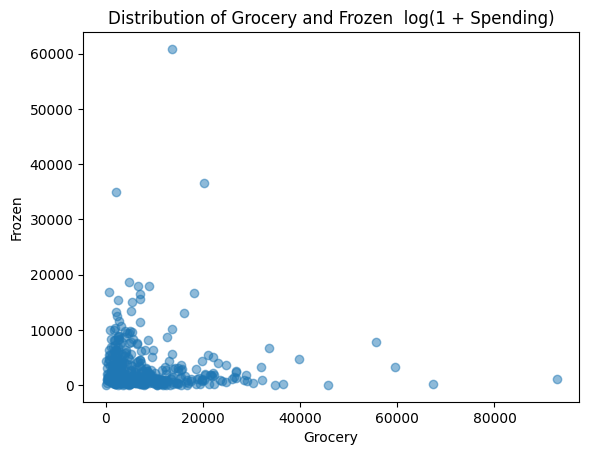

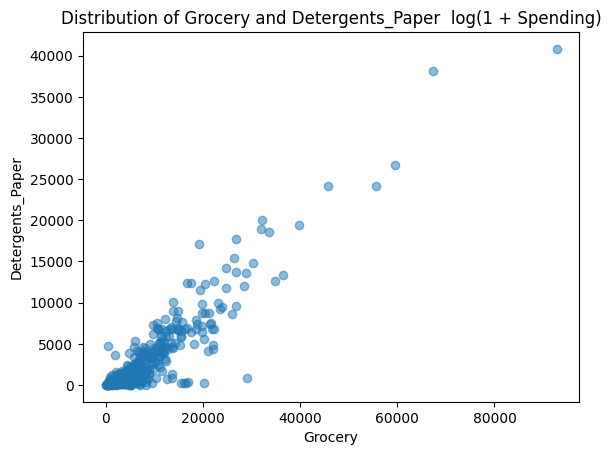

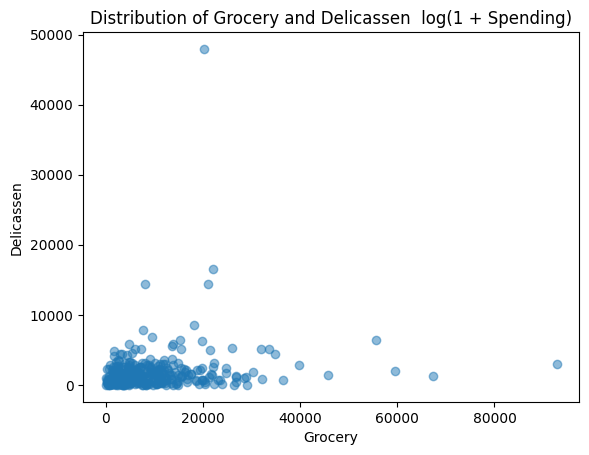

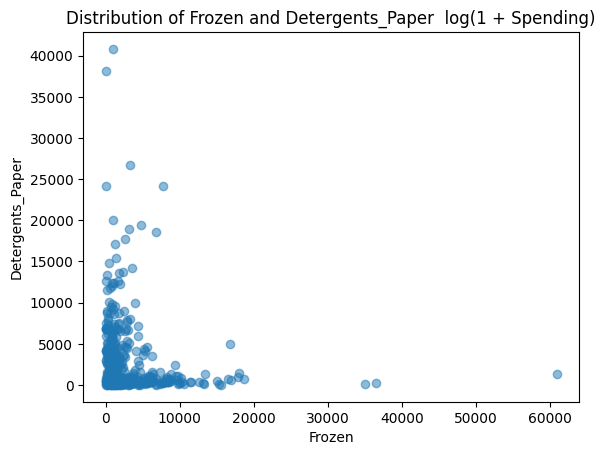

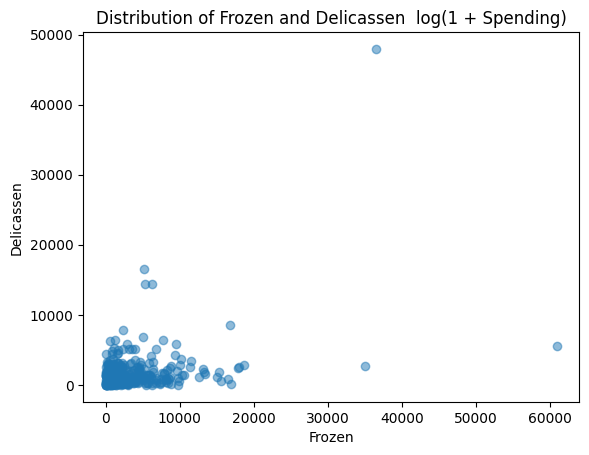

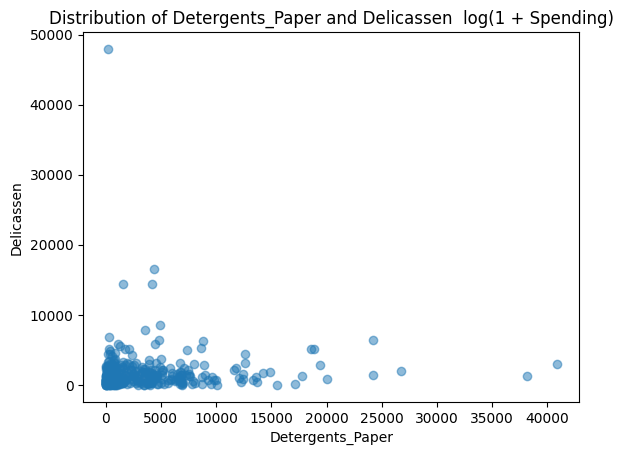

In [112]:

# Reading UCI Data as Numpy Array
uci_data = np.genfromtxt('Wholesale_customers_data.csv', delimiter=',', skip_header=1) # No need to read the header as data

# Reading headers of UCI Data
headers = np.genfromtxt('Wholesale_customers_data.csv', delimiter=',', dtype=str, max_rows=1)

# Dropping Channel and Region Columns from UCI Data
uci_data = uci_data[:,2:]

# Dropping Channel and Region from UCI headers
headers = headers[2:]

# Fetching the shape UCI Data
N,d = uci_data.shape

# Plotting histogram for not log transformed data
plot_histograms(uci_data, headers, 'Spending')

# Plotting scatter plots for not log transformed data
generate_scatter_plots(uci_data, headers, 'Spending')

# Log Transform of UCI Data ( Adding 1 as some values in dataset can be zero)
log_uci_data = np.log(uci_data + 1)

# Plotting histogram for log transformed data
plot_histograms(log_uci_data, headers, 'log(1 + Spending)')

# Plotting scatter plots for log transformed data
generate_scatter_plots(uci_data, headers, 'log(1 + Spending)')


## Part 2 - Detecting Anomalies

min_average_spread :  1.7976931348623157e+308
Best_gamma is :  0.9402013422818791


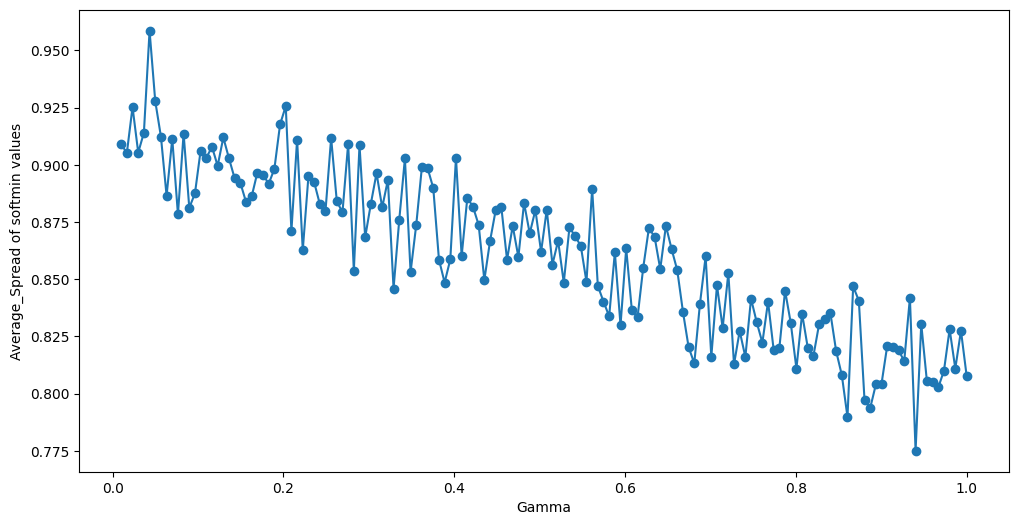

In [113]:

uci_data_with_index = None
# to prevent column addition multiple times on multiple run of the code
if(uci_data_with_index == None or uci_data_with_index.shape[1] < 7):
    x = np.arange(uci_data.shape[0])
    # Adding index column in numpy data 
    uci_data_with_index = np.insert(uci_data, 0, values=x, axis=1)

gamma_values = np.linspace(0.01, 1.0, num=150) # Different gamma values to assess robustness
bootstrap_iterations = 15  # Number of bootstrapping iterations

best_gamma = sys.float_info.max
min_average_spread = sys.float_info.max

print("min_average_spread : ", min_average_spread)

gamma_array = []
average_spread_array = []

for gamma in gamma_values:
    anomaly_scores_bootstrap = []
    
    for _ in range(bootstrap_iterations):
        # Perform bootstrap sampling with repetition - , random_state=42
        bootstrap_sample = resample(log_uci_data, replace=False, n_samples=N//2, stratify=log_uci_data)
        anomaly_scores = calculate_anomaly_scores(N//2, bootstrap_sample, gamma)
        anomaly_scores_bootstrap.append(anomaly_scores)

    anomaly_scores_bootstrap = np.array(anomaly_scores_bootstrap)
    spread = np.std(anomaly_scores_bootstrap, axis=0) 
    average_spread = np.mean(spread)
    gamma_array.append(gamma)
    average_spread_array.append(average_spread)
    if(min_average_spread > average_spread):
        min_average_spread = average_spread
        best_gamma = gamma
    

print("Best_gamma is : ", best_gamma) 

# plot the graph and verify best gamma
gamma_spread_data = pd.DataFrame({'Gamma':gamma_array, 'Average_Spread':average_spread_array})
plt.figure(figsize=(12,6))
plt.plot(gamma_spread_data['Gamma'], gamma_spread_data['Average_Spread'], marker='o')
plt.xlabel('Gamma')
plt.ylabel('Average_Spread of softmin values')
plt.show()


In [114]:
# Rank instances and extract top anomalies for the original dataset with 440 instances for best gamma 
anomaly_scores_best = calculate_anomaly_scores(N, log_uci_data, best_gamma)
top_anomalies = extract_top_anomalies(N, anomaly_scores_best, top_k=10)

headers_with_anomaly_score = np.append(headers,'Anomaly_Score')
uci_data_with_anomaly_score = None
if(uci_data_with_anomaly_score == None or uci_data_with_anomaly_score.shape[1] < 7):
    uci_data_with_anomaly_score = np.insert(uci_data, 6, values=anomaly_scores_best, axis=1)

data_with_anomaly_score = pd.DataFrame(data=uci_data_with_anomaly_score, index=range(N), columns=headers_with_anomaly_score) 
anomalous_instances = data_with_anomaly_score.iloc[top_anomalies.Instance.tolist()]

print("Top Anomalies are : \n")
print(anomalous_instances.to_string())

Top Anomalies are : 

       Fresh     Milk  Grocery   Frozen  Detergents_Paper  Delicassen  Anomaly_Score
338      3.0    333.0   7021.0  15601.0              15.0       550.0       8.767921
154    622.0     55.0    137.0     75.0               7.0         8.0       8.215997
75   20398.0   1137.0      3.0   4407.0               3.0       975.0       8.138716
95       3.0   2920.0   6252.0    440.0             223.0       709.0       7.270512
142  37036.0   7152.0   8253.0   2995.0              20.0         3.0       6.773548
66       9.0   1534.0   7417.0    175.0            3468.0        27.0       6.727107
128    140.0   8847.0   3823.0    142.0            1062.0         3.0       6.580738
218     18.0   7504.0  15205.0   1285.0            4797.0      6372.0       6.148629
65      85.0  20959.0  45828.0     36.0           24231.0      1423.0       6.123638
109   1406.0  16729.0  28986.0    673.0             836.0         3.0       6.114323


## 3 - Explainable AI

In [115]:
anomaly_scores_for_best_gamma = calculate_anomaly_scores(N, log_uci_data, best_gamma)

distance_matrix = cdist(log_uci_data, log_uci_data)
numerator =  np.exp( (-1) * best_gamma * distance_matrix ) 

print(numerator[0])

# Rk values for point j 
Rjk = np.zeros((N,N))

for j in range(N):
    denom = np.sum(numerator[j]) - 1
    Rjk[j] = (numerator[j]/denom) * anomaly_scores_best[j]


# Ri values for point j
Rji = np.zeros((6,440))


# 6 features
for i in range(d):  
    # 440 points
    for j in range(N):
        sum = 0
        for k in range(N):
            if(k!=j):
                euclidean_dist = np.linalg.norm(log_uci_data[j]-log_uci_data[k])
                squared_euclidean_dist = np.square(euclidean_dist)
                vector_diff = np.subtract(log_uci_data[j] , log_uci_data[k])
                vector_diff_squared = np.square(vector_diff)
                sum += (vector_diff_squared[i]/squared_euclidean_dist) * Rjk[j][k]
        Rji[i][j] = sum 

# 440 * 6        
Rji = Rji.T


# Verification Part : Rji == Softmin Scores (Conservation Property)
softmin_verification_arr = np.sum(Rji, axis = 1)
print("softmin_verification_arr shape is : ", softmin_verification_arr.shape)



softmin_verification_arr_rd = softmin_verification_arr.round(decimals=2)
print("softmin_verification_arr_rd : ", softmin_verification_arr_rd)

anomaly_scores_for_best_gamma_np = np.array(anomaly_scores_for_best_gamma)
anomaly_scores_for_best_gamma_rd = anomaly_scores_for_best_gamma_np.round(decimals=2)

diff = np.subtract(softmin_verification_arr_rd, anomaly_scores_for_best_gamma_rd)

print(diff)
print(min(diff))
print(max(diff))


# As min is zero and max is also zero, this means all other values are 0 and hence the results are very much reproducible


[1.00000000e+00 1.23494759e-01 5.49864543e-02 1.64856751e-02
 4.36320909e-02 2.92371533e-01 2.12885680e-01 1.11817528e-01
 2.22600683e-01 1.10271281e-01 3.74004848e-02 3.88522579e-02
 2.70446909e-01 5.49358683e-02 3.28399728e-01 7.03105578e-02
 8.15324669e-02 6.04499307e-02 8.96363338e-02 1.39880431e-01
 1.62431677e-01 1.43307909e-02 1.59408916e-02 1.47933541e-02
 5.18938579e-02 4.57598693e-02 1.57153282e-02 1.60410783e-02
 5.59924402e-02 6.02448972e-02 1.28482332e-01 4.70613958e-02
 7.25106921e-02 2.19687459e-02 3.20701128e-02 3.72415073e-02
 6.29914519e-02 9.49469389e-02 7.64149559e-02 3.37645887e-03
 1.74753057e-02 8.10569066e-02 3.51387112e-02 1.20157578e-02
 4.75651571e-02 5.34793984e-02 6.62861173e-02 6.47107493e-03
 2.85515093e-01 4.76370908e-02 1.89772871e-02 1.20463461e-01
 1.92640494e-01 2.32317465e-02 1.74921413e-02 1.35627869e-01
 2.97261966e-02 1.26698271e-01 3.27955928e-02 3.59894225e-01
 1.11050513e-01 1.47718685e-02 5.51591316e-02 6.40758167e-02
 2.73131312e-02 3.352209

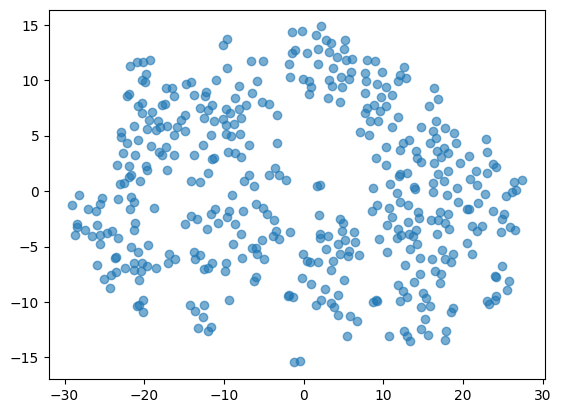

In [116]:
tsne = TSNE()
tsne_rep = tsne.fit_transform(log_uci_data)
plt.scatter(tsne_rep[:, 0], tsne_rep[:, 1], alpha=0.6)
plt.show()

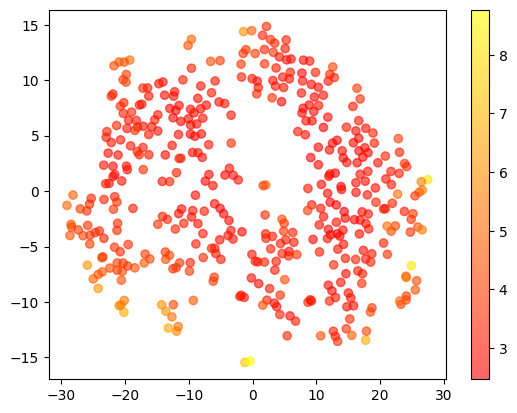

In [117]:
tsne = TSNE()
tsne_rep = tsne.fit_transform(log_uci_data)
plt.scatter(tsne_rep[:, 0], tsne_rep[:, 1], alpha=0.6, c=softmin_verification_arr, cmap = 'autumn')
plt.colorbar()
plt.show()

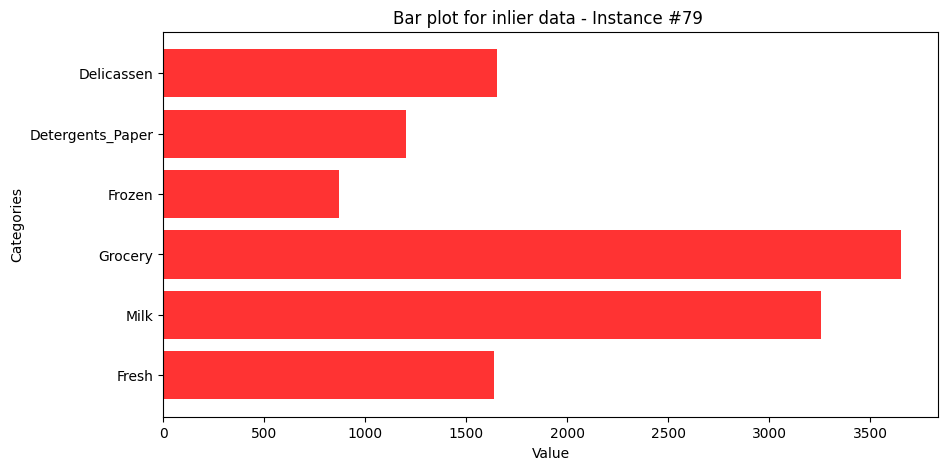

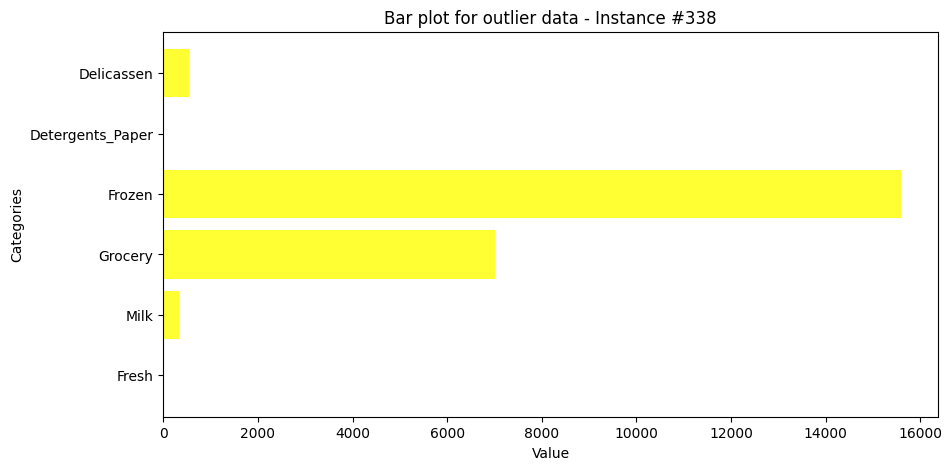

In [118]:
# Bar plot for inlier data
plt.figure(figsize=(10,5))
plt.barh(headers, uci_data[79,:], alpha=0.8, color = 'red')
plt.title('Bar plot for inlier data - Instance #79 ')
plt.ylabel('Categories')
plt.xlabel('Value')
plt.show()

# Bar plot for outlier data
plt.figure(figsize=(10,5))
plt.barh(headers, uci_data[338,:], alpha=0.8, color = 'yellow')
plt.title('Bar plot for outlier data - Instance #338')
plt.ylabel('Categories')
plt.xlabel('Value')
plt.show()

## Part 4 - Cluster Analysis

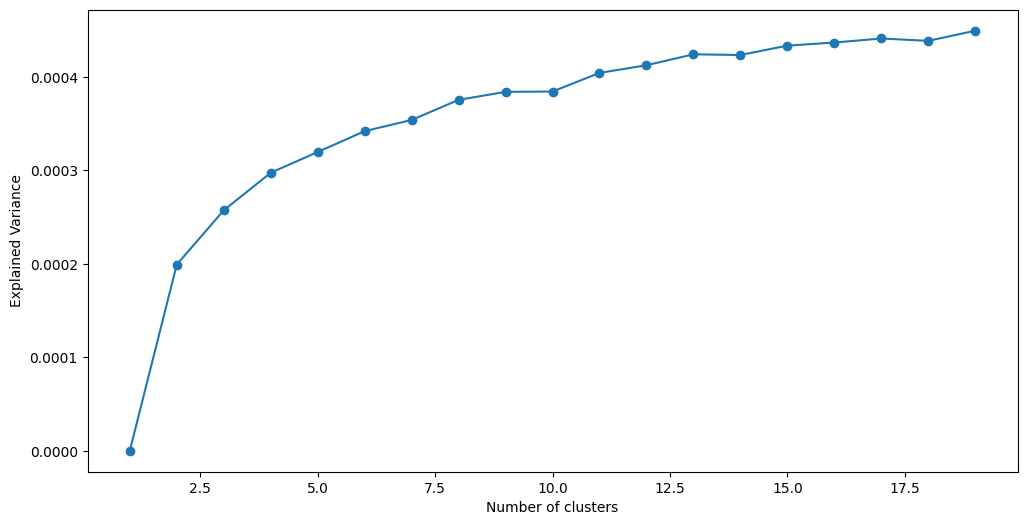

In [119]:
# Removing top 10 anomalous instances for best gamma
instances_to_be_deleted = top_anomalies.Instance.tolist()
log_uci_data_with_index = None
if(log_uci_data_with_index == None or log_uci_data_with_index.shape[1] < 7):
    x = np.arange(N)
    log_uci_data_with_index = np.insert(log_uci_data, 0, values=x, axis=1)

if(log_uci_data_with_index.shape[0] > 430):
    log_uci_data_with_index = np.delete(log_uci_data_with_index, instances_to_be_deleted , axis= 0)

explaind_var_list = []

# Trying for cluster size from 1 to 20
for k in range(1,20):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(log_uci_data_with_index[:, 1:])
    Y = kmeans.predict(log_uci_data_with_index[:, 1:])
    
    centers = kmeans.cluster_centers_
    total_var = np.var(log_uci_data_with_index, axis=0).sum()
    bw_cluster_var = np.var(centers[Y], axis=0).sum() 
    explained_variance = bw_cluster_var / total_var
    explaind_var_list.append(explained_variance)


# Converting the results of capturing intertia for various K values into a dataframe and plotting them
df2 = pd.DataFrame({'Cluster':range(1,20), 'Explained_Variance':explaind_var_list})
plt.figure(figsize=(12,6))
plt.plot(df2['Cluster'], df2['Explained_Variance'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Explained Variance')
plt.show()


# From elbow method we see that the optimum value of K i.e. number of clusters is  2


Average Spending per category for the entire dataset is as below : 
 
Fresh  :  6367.767702597013
Milk  :  3823.1249348609476
Grocery  :  5384.78412072424
Frozen  :  1408.6516348935697
Detergents_Paper  :  1171.1275915148135
Delicassen  :  854.2088855608731


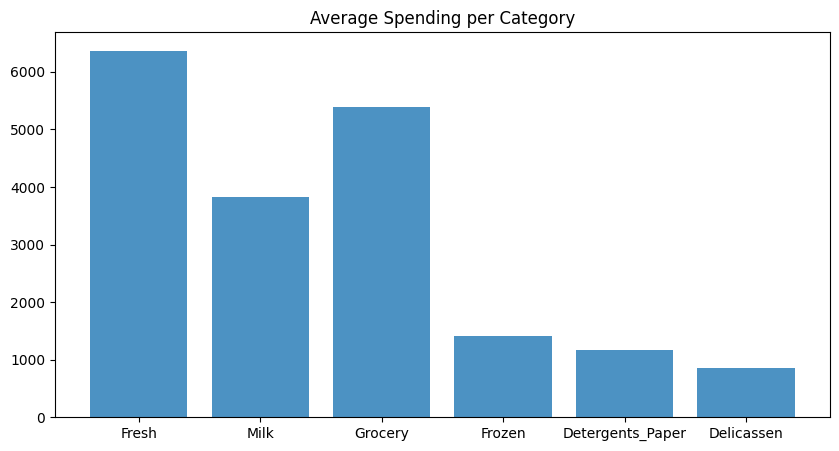

In [120]:
# Getting centroids for the clusters = 2 
kmeans = KMeans(n_clusters=2, n_init='auto')
kmeans.fit(log_uci_data_with_index[:, 1:])
Y = kmeans.predict(log_uci_data_with_index[:, 1:])
centroids  = kmeans.cluster_centers_

# Finding Average spending data per category for the entire dataset
mean = np.mean(centroids, axis = 0)
delog_data_average_spending_per_category = np.exp(mean) - 1
print("Average Spending per category for the entire dataset is as below : \n ")
for m in range(d):
    print(headers[m] , " : ", delog_data_average_spending_per_category[m])
    

# Bar plot to show average spending per category
plt.figure(figsize=(10,5))
plt.bar(headers, delog_data_average_spending_per_category, alpha=0.8)
plt.title("Average Spending per Category")
plt.show()



Average Spending per category for the first cluster is as below : 
 
Fresh  :  8784.519461931934
Milk  :  1919.435070953306
Grocery  :  2428.2506645394333
Frozen  :  2133.0648638671823
Detergents_Paper  :  292.02548125220574
Delicassen  :  717.2234345097747


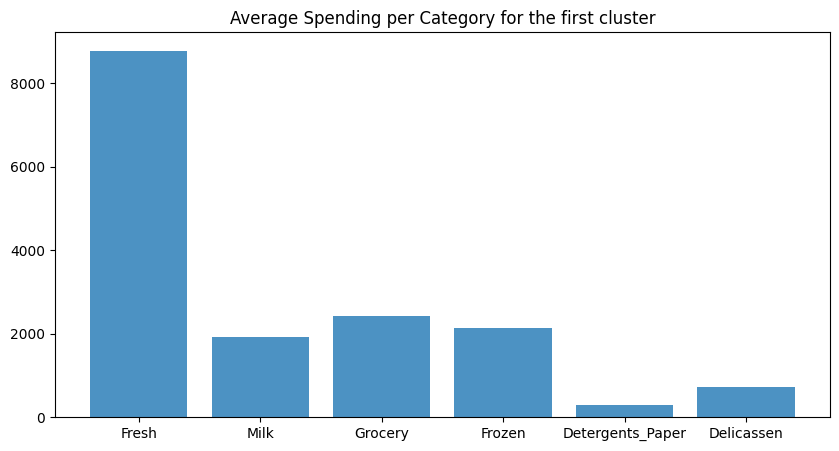

In [121]:
# Finding Average spending data per category for the first cluster
mean_1 = centroids[0]
delog_data_average_spending_per_category = np.exp(mean_1) - 1
print("\n\nAverage Spending per category for the first cluster is as below : \n ")
for m in range(d):
    print(headers[m] , " : ", delog_data_average_spending_per_category[m])
    
# Bar plot to show average spending per category for the first cluster
plt.figure(figsize=(10,5))
plt.bar(headers, delog_data_average_spending_per_category, alpha=0.8)
plt.title("Average Spending per Category for the first cluster")
plt.show()



Average Spending per category for the first cluster is as below : 
 
Fresh  :  4615.824562895382
Milk  :  7613.905465231851
Grocery  :  11939.583579317365
Frozen  :  930.1421435228627
Detergents_Paper  :  4687.613034331382
Delicassen  :  1017.32132286449


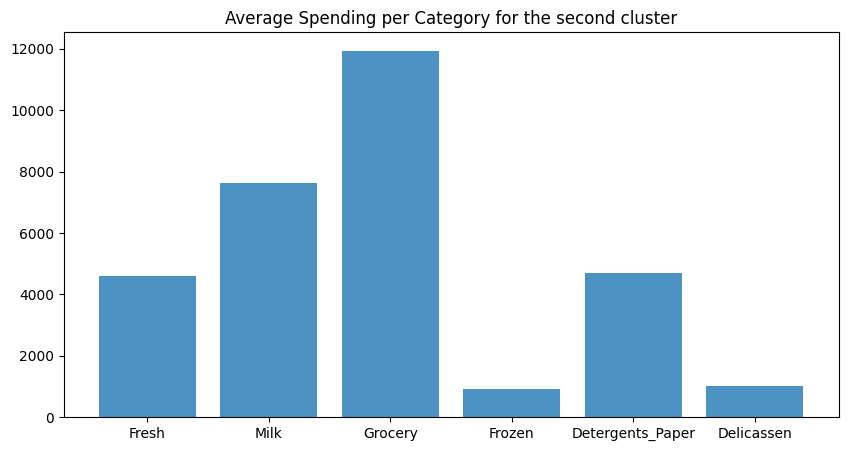

In [122]:
# Finding Average spending data per category for the second cluster
mean_2 = centroids[1]
delog_data_average_spending_per_category = np.exp(mean_2) - 1
print("\n\nAverage Spending per category for the first cluster is as below : \n ")
for m in range(d):
    print(headers[m] , " : ", delog_data_average_spending_per_category[m])
    
# Bar plot to show average spending per category for the second cluster
plt.figure(figsize=(10,5))
plt.bar(headers, delog_data_average_spending_per_category, alpha=0.8)
plt.title("Average Spending per Category for the second cluster")
plt.show()